In [1]:
from hep_ml import splot

In [2]:
from scipy.stats import norm

In [3]:
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report

import lightgbm as lgb

from aux_functions import fit_line, invert_regr

In [4]:
df_ER_train = pd.read_csv('csv_data/df_ER.csv', index_col='Unnamed: 0')
df_NR_train = pd.read_csv('csv_data/df_NR.csv', index_col='Unnamed: 0')
df_train = pd.concat([df_ER_train, df_NR_train])
df_private = pd.read_csv('csv_data/df_private_test.csv', index_col='Unnamed: 0')

In [5]:
df_private['abs_dmu_x'] = np.abs(df_private['mu_x'] - 288)
df_private['abs_dmu_y'] = np.abs(df_private['mu_y'] - 288)

## calibration

In [6]:
cut_ER = f'event_energy>=1 and event_class == "ER" and (event_energy<=20)'
X_ER = df_train.query(cut_ER).sig_count_y
y_ER = df_train.query(cut_ER).event_energy
a_ER, b_ER = np.polyfit(y_ER, X_ER, deg=1)

In [7]:
cut_NR = 'event_energy>=3 and event_energy<=30 and event_class == "NR"'
X_NR = df_train.query(cut_NR).sig_count_y
y_NR = df_train.query(cut_NR).event_energy
X_NR = np.concatenate([X_NR, int(1e5)*[0]])
y_NR = np.concatenate([y_NR, int(1e5)*[1]])
a_NR, b_NR = np.polyfit(y_NR, X_NR, deg=1)

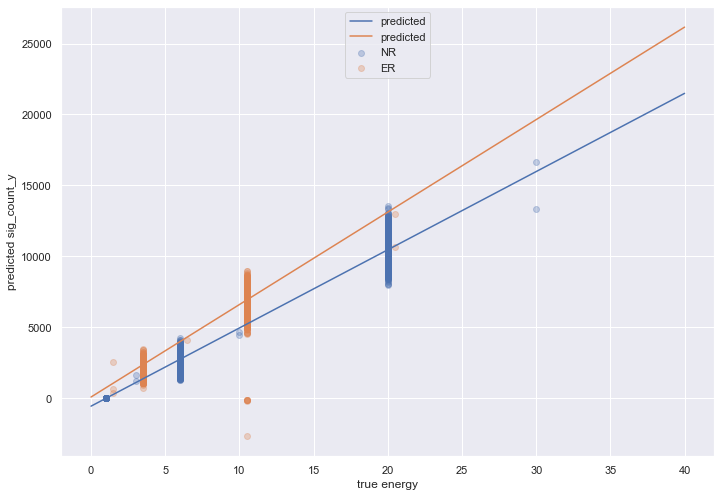

In [8]:
xmin, xmax = 0, 40
plt.scatter(y_NR, X_NR, label='NR', alpha=0.3)
plt.plot([xmin, xmax], a_NR*np.array([xmin, xmax])+b_NR, label='predicted')
# plt.xlim(6, 7)
# plt.ylim(3000, 5000)
plt.xlabel('true energy')
plt.ylabel('predicted sig_count_y')
plt.legend(loc='upper center')

plt.scatter(y_ER + 0.5*np.ones_like(y_ER), X_ER, label='ER', alpha=0.3)
plt.plot([xmin, xmax], a_ER*np.array([xmin, xmax])+b_ER, label='predicted')
# plt.scatter(30*np.ones_like(E_pred_30_synth), E_pred_30_synth, label='synthetic')
# plt.plot([xmin,xmax], [xmin,xmax])
plt.xlabel('true energy')
plt.ylabel('predicted sig_count_y')
plt.legend(loc='upper center')

plt.show()

## MID

In [9]:
MID_left, MID_right = 2500, 6700
df_private_MID = df_private.query(f'sig_count_y > {MID_left} and sig_count_y < {MID_right}')

In [10]:
E_expected_NR_MID = a_NR*10+b_NR
E_expected_NR_MID = E_expected_NR_MID - 200 # correcting calibration
E_expected_NR_MID

4755.880957650817

In [11]:
E_expected_ER_MID = a_ER*6+b_ER
E_expected_ER_MID

3999.4948670416866

In [12]:
# E_expected_ER_MID = 4200 # correcting calibration
# E_expected_ER_MID

In [13]:
x = np.linspace(MID_left, MID_right)
sigma_ER_MID = 580 # 580
sigma_NR_MID = 580
E_ER_MID = norm.pdf(x, loc=E_expected_ER_MID, scale=sigma_ER_MID)
E_NR_MID = norm.pdf(x, loc=E_expected_NR_MID, scale=sigma_NR_MID) # -200
E_total_MID = 0.5*E_ER_MID+0.5*E_NR_MID

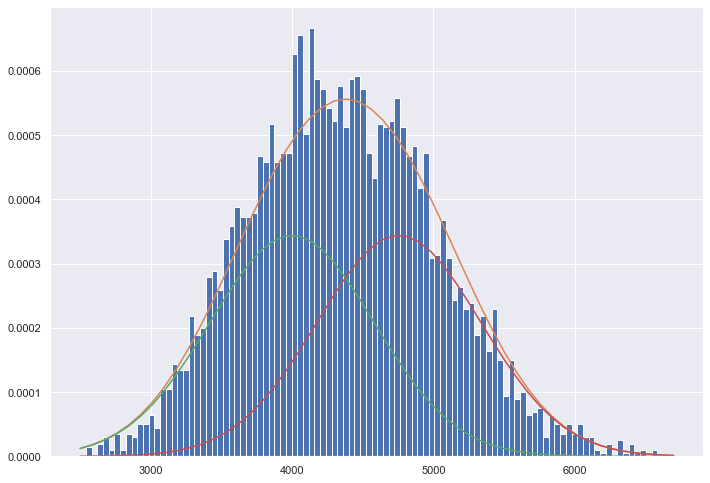

In [14]:
plt.hist(df_private_MID.sig_count_y, density=True, bins=100)
# plt.vlines([E_expected_NR_10, E_expected_ER_6], ymin=0, ymax=120, linewidth=3, color='orange')
plt.plot(x, E_total_MID)
plt.plot(x, 0.5*E_ER_MID)
plt.plot(x, 0.5*E_NR_MID)
plt.show()

In [15]:
probs_MID = pd.DataFrame(dict(sig=norm.pdf(df_private_MID.sig_count_y, loc=E_expected_ER_MID, scale=sigma_ER_MID), bck=norm.pdf(df_private_MID.sig_count_y, loc=E_expected_NR_MID, scale=sigma_NR_MID)))
probs_MID = probs_MID.div(probs_MID.sum(axis=1), axis=0)

(<matplotlib.legend.Legend at 0x7fdc61edc0a0>, Text(0.5, 0, 'sc'))

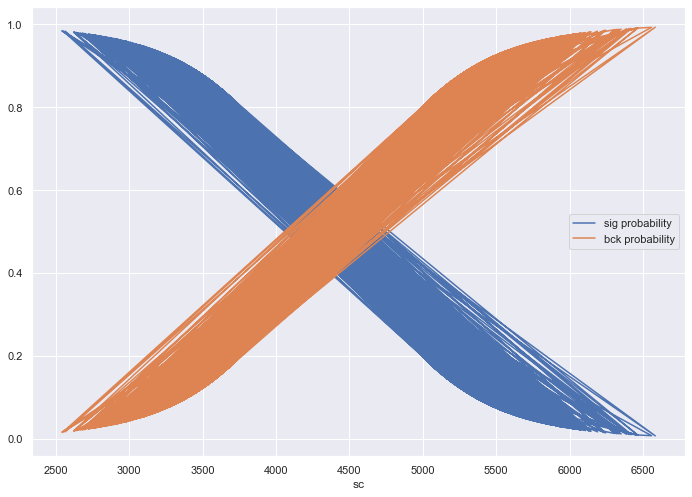

In [16]:
plt.plot(df_private_MID.sig_count_y, probs_MID.sig, label='sig probability')
plt.plot(df_private_MID.sig_count_y, probs_MID.bck, label='bck probability')
plt.legend(), plt.xlabel('sc')

In [17]:
sWeights_MID = splot.compute_sweights(probs_MID)

In [18]:
df_private_MID.columns

Index(['N_bkgr_only_x', 'N_bkgr_only_y', 'N_error_bkgr_only_x',
       'N_error_bkgr_only_y', 'N_error_x', 'N_error_y', 'N_x', 'N_y',
       'bkgr_count_x', 'bkgr_count_y',
       ...
       'tolerance_bkgr_only_x', 'tolerance_bkgr_only_y', 'tolerance_x',
       'tolerance_y', 'up_bkgr_only_x', 'up_bkgr_only_y', 'up_x', 'up_y',
       'abs_dmu_x', 'abs_dmu_y'],
      dtype='object', length=118)

In [19]:
#               'chi2_pvalue_x', 'chi2_pvalue_y', 
#               'dfr', 
#               'dmu', 'dsigma', 
#               'sigma_x', 'sigma_y', 
#               'mu_x', 'mu_y',
#               'abs_dmu_x', 'abs_dmu_y',
#               'n_excess_bins_x', 'n_excess_bins_y', 

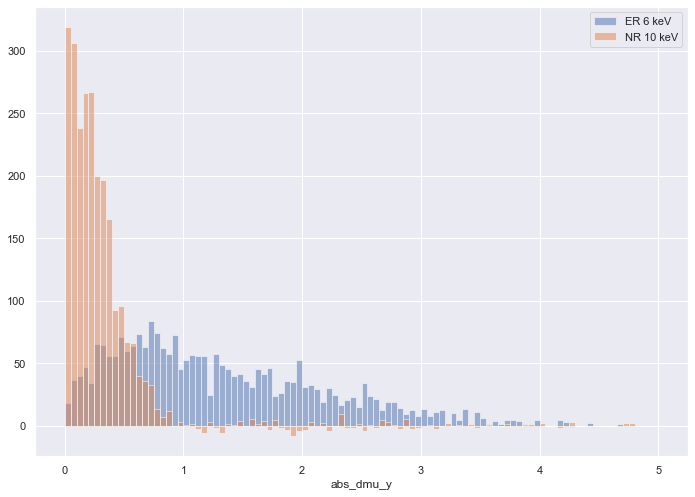

In [20]:
feature = 'abs_dmu_y'
plt.hist(df_private_MID[feature], weights=sWeights_MID.sig, bins=100, range=(0, 5), label='ER 6 keV', alpha=0.5)
plt.hist(df_private_MID[feature], weights=sWeights_MID.bck, bins=100, range=(0, 5), label='NR 10 keV', alpha=0.5)
plt.legend()
plt.xlabel(feature)
plt.show()

## LOW

In [21]:
LOW_left, LOW_right = 0, 2500
df_private_LOW = df_private.query(f'sig_count_y > {LOW_left} and sig_count_y < {LOW_right}')

In [22]:
E_expected_NR_LOW = a_NR*3+b_NR
# E_expected_NR_LOW -= 50

In [23]:
E_expected_ER_LOW = a_ER*1+b_ER
E_expected_ER_LOW += 80

In [24]:
x = np.linspace(LOW_left, LOW_right)
sigma_ER_LOW = 300
sigma_NR_LOW = 420
E_ER_LOW = norm.pdf(x, loc=E_expected_ER_LOW, scale=sigma_ER_LOW)
E_NR_LOW = norm.pdf(x, loc=E_expected_NR_LOW, scale=sigma_NR_LOW)
E_total_LOW = 0.5*E_ER_LOW+0.5*E_NR_LOW

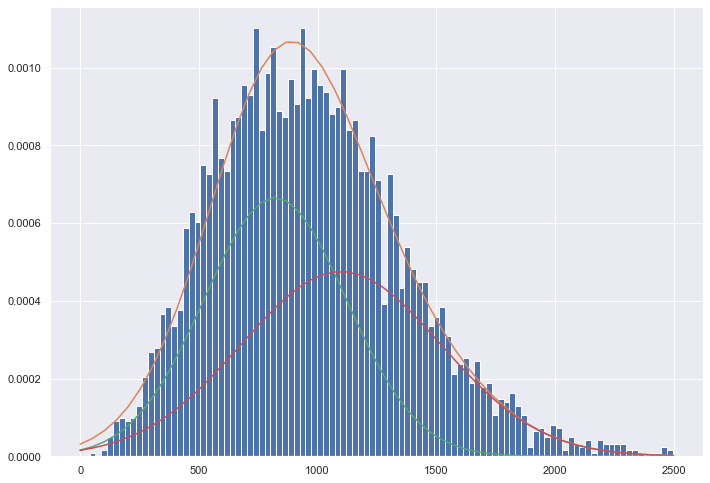

In [25]:
plt.hist(df_private_LOW['sig_count_y'], density=True, bins=100)
# plt.vlines([E_expected_NR_10, E_expected_ER_6], ymin=0, ymax=120, linewidth=3, color='orange')
plt.plot(x, E_total_LOW)
plt.plot(x, 0.5*E_ER_LOW)
plt.plot(x, 0.5*E_NR_LOW)
plt.show()

In [26]:
probs_LOW = pd.DataFrame(dict(sig=norm.pdf(df_private_LOW.sig_count_y, loc=E_expected_ER_LOW, scale=sigma_ER_LOW), bck=norm.pdf(df_private_LOW.sig_count_y, loc=E_expected_NR_LOW, scale=sigma_NR_LOW)))
probs_LOW = probs_LOW.div(probs_LOW.sum(axis=1), axis=0)

In [27]:
sWeights_LOW = splot.compute_sweights(probs_LOW)

In [28]:
#               'chi2_pvalue_x', 'chi2_pvalue_y', 
#               'dfr', 
#               'dmu', 'dsigma', 
#               'sigma_x', 'sigma_y', 
#               'mu_x', 'mu_y',
#               'abs_dmu_x', 'abs_dmu_y',
#               'n_excess_bins_x', 'n_excess_bins_y', 

In [29]:
([c for c in df_private_LOW.columns if 'bkgr_only' in c])

['N_bkgr_only_x',
 'N_bkgr_only_y',
 'N_error_bkgr_only_x',
 'N_error_bkgr_only_y',
 'chi2_bkgr_only_x',
 'chi2_bkgr_only_y',
 'chi2_pvalue_bkgr_only_x',
 'chi2_pvalue_bkgr_only_y',
 'edm_bkgr_only_x',
 'edm_bkgr_only_y',
 'fval_bkgr_only_x',
 'fval_bkgr_only_y',
 'has_accurate_covar_bkgr_only_x',
 'has_accurate_covar_bkgr_only_y',
 'has_covariance_bkgr_only_x',
 'has_covariance_bkgr_only_y',
 'has_made_posdef_covar_bkgr_only_x',
 'has_made_posdef_covar_bkgr_only_y',
 'has_parameters_at_limit_bkgr_only_x',
 'has_parameters_at_limit_bkgr_only_y',
 'has_posdef_covar_bkgr_only_x',
 'has_posdef_covar_bkgr_only_y',
 'has_reached_call_limit_bkgr_only_x',
 'has_reached_call_limit_bkgr_only_y',
 'has_valid_parameters_bkgr_only_x',
 'has_valid_parameters_bkgr_only_y',
 'hesse_failed_bkgr_only_x',
 'hesse_failed_bkgr_only_y',
 'is_above_max_edm_bkgr_only_x',
 'is_above_max_edm_bkgr_only_y',
 'is_valid_bkgr_only_x',
 'is_valid_bkgr_only_y',
 'nfcn_bkgr_only_x',
 'nfcn_bkgr_only_y',
 'nfcn_total_b

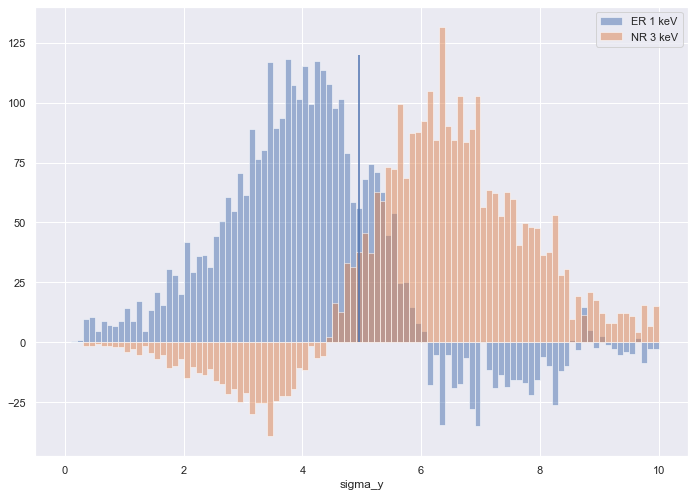

In [30]:
feature = 'sigma_y'
plt.hist(df_private_LOW[feature], weights=sWeights_LOW.sig, bins=100, range=(0, 10), label='ER 1 keV', alpha=0.5)  # range=(0, 5),
plt.hist(df_private_LOW[feature], weights=sWeights_LOW.bck, bins=100, range=(0, 10), label='NR 3 keV', alpha=0.5)  # range=(0, 5),
plt.legend()
plt.xlabel(feature)
plt.vlines(4.95, 0, 120)
plt.show()

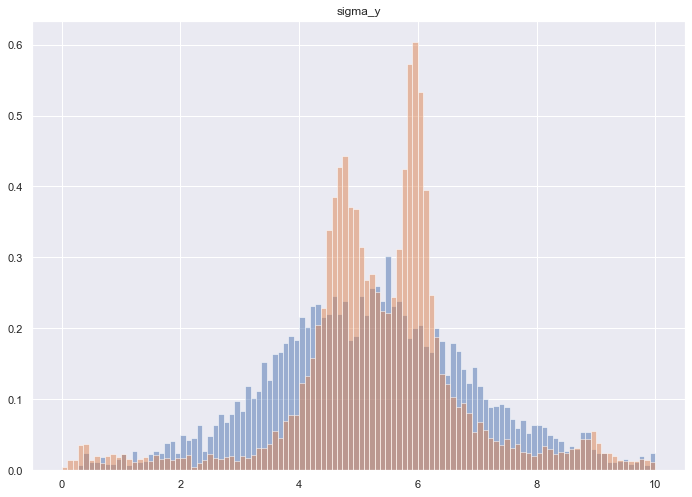

In [31]:
plt.hist(df_private_LOW[feature], bins=110, range=(0, 10), alpha=0.5, density=True)
plt.hist(df_train[feature], bins=110, range=(0, 10), alpha=0.5, density=True)
plt.title(feature)
plt.show()

## training on sWeights

In [32]:
LOW_vars = [  
#     'chi2_pvalue_x', 'chi2_pvalue_y', 
#                'chi2_x', 'chi2_y',
#               'dfr', 
#               'dmu', 'dsigma', 
#               'fr_error_x', 'fr_error_y', 
#               'fr_x', 'fr_y',
              'sigma_x', 
              'sigma_y', 
#               'sigma_error_x', 'sigma_error_y', 
              'mu_x', 'mu_y', 
#               'mu_error_x', 'mu_error_y', 
#               'n_excess_bins_x', 'n_excess_bins_y', 
#                'nfcn_total_x', 'nfcn_total_y',
#        'nfcn_x', 'nfcn_y', 'ngrad_total_x', 'ngrad_total_y', 'ngrad_x', 'ngrad_y', 
#               'sig_count_x', 
#                'sig_count_y', 
#               'sig_density_x', 'sig_density_y', 
#         'abs_dmu_x', 'abs_dmu_y',
#                'dsig_count'
]

In [33]:
df_sig = df_private_LOW[LOW_vars]
df_sig['w'] = sWeights_LOW.sig.values
df_sig['target'] = 1
#
df_bkgr = df_private_LOW[LOW_vars]
df_bkgr['w'] = sWeights_LOW.bck.values
df_bkgr['target'] = 0
#
df_sb = pd.concat([df_sig, df_bkgr])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [34]:
X = df_sb[LOW_vars]
y = df_sb['target']
w = df_sb['w']

In [35]:
clf_params ={
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'max_depth': 4,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 777
}

In [36]:
lgb_sTrain = lgb.Dataset(X, y, weight=w, free_raw_data=False)
sClf = lgb.train(
                clf_params,
                lgb_sTrain,
                num_boost_round=1000,
               )

In [37]:
sPred = sClf.predict(X)

In [38]:
df_sig.shape

(4991, 6)

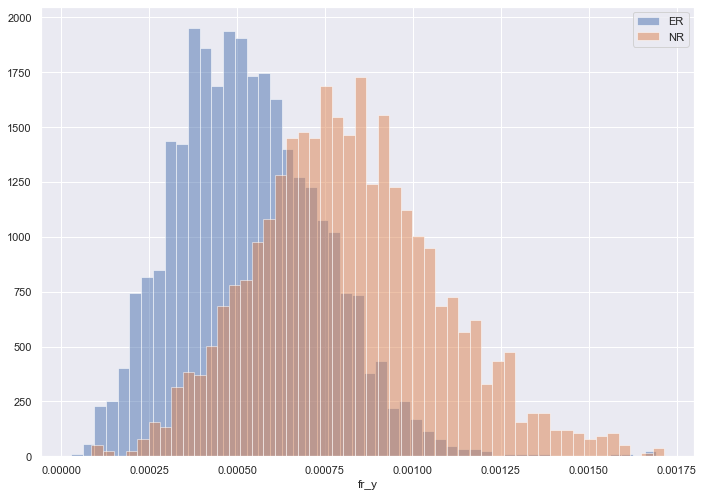

In [48]:
var = 'fr_y'
len_private = df_private_LOW.shape[0]
plt.hist(df_private_LOW[sPred[:len_private] == 1][var], bins=50, alpha=0.5,  density=True, label='ER')
plt.hist(df_private_LOW[sPred[:len_private] == 0][var], bins=50, alpha=0.5,  density=True, label='NR')
plt.legend()
plt.xlabel(var)
plt.show()

In [40]:
sER_image_names = df_private_LOW[sPred[:len_private] == 1].image_name
sNR_image_names = df_private_LOW[sPred[:len_private] == 0].image_name

In [41]:
submission = pd.read_csv('pipeline_Oleg.csv', index_col='id')

In [42]:
len(submission.query('classification_predictions * regression_predictions == 1'))

2187

In [43]:
len(submission.loc[sER_image_names].query('classification_predictions * regression_predictions == 1'))

2162

In [44]:
len(sER_image_names)

2617